In [1]:
import numpy as np

from sklearn.metrics import confusion_matrix
from hmmlearn import hmm

import gzip
import itertools
import pickle
import time

import matplotlib.pyplot as plt
from ssm.util import find_permutation

%matplotlib inline

In [2]:
def hill_curve_001(x):
    # return 0.185 + (0.867-0.185)*x**1.18 / (68.0**1.18 + x**1.18)
    return (0.168 + (1.07-0.168)*x**0.792 / (112.0**0.792 + x**0.792)) * 100

In [3]:
def make_plots(Z, Z_hat):
    order = Z.argsort()

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,2), sharey=True)
    ax1.imshow(Z[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z.shape[0] - 0.5, 0, 1), cmap="jet")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(Z_hat[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat.shape[0] - 0.5, 0, 1), cmap="jet")
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.show()

    cm = confusion_matrix(Z, Z_hat)

    cm_best_ = cm.copy()
    cm_best_a_ = np.diag(cm_best_).sum()
    for p in itertools.permutations(np.arange(cm.shape[0])):
        cm_ = cm[p, :].copy()
        cm_a_ = np.diag(cm_).sum()
        if cm_a_ > cm_best_a_:
            cm_best_ = cm_.copy()
            cm_best_a_ = cm_a_
    print(cm_best_)
    print(cm_best_a_ / cm_best_.sum())

## Generating Data

In [4]:
K = 3
T = 5000

model_1 = hmm.GaussianHMM(n_components=K, covariance_type="diag")

model_1.startprob_ = np.array([0.6, 0.3, 0.1])
model_1.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.1, 0.8, 0.1],
                            [0.05, 0.05, 0.9]])
model_1.means_ = np.array([[0.0], [50.0], [100.0]])
model_1.covars_ = np.tile(np.ones(1), (K, 1))

def prep_(dat, t=7):
    X, Z = dat
    X_ = X.copy()
    X_ = X_.cumsum()
    X_ = (X_[t:] - X_[:-t])
    X = hill_curve_001(X_+10)
    X, Z = X.reshape(-1, 1), Z[t:]
    return X, Z, dat[0]

sample = [prep_(model_1.sample(T)) for  _ in range(1000)]

X, Z, X_ = np.concatenate([xz[0] for xz  in sample]), np.concatenate([xz[1] for xz  in sample]), np.concatenate([xz[2] for xz  in sample])
L = [len(xz[0]) for xz in sample]

# f = gzip.open('data_hmm_004.pcklz', 'wb')
# pickle.dump(X, f)
# pickle.dump(Z, f)
# f.close()

X[np.isnan(X)] = 0.00

f = gzip.open('data_hmm_004a.pcklz', 'wb')
pickle.dump(X, f)
pickle.dump(Z, f)
f.close()

/tmp/ipykernel_3567843/1592173968.py:3: RuntimeWarning: invalid value encountered in power
  return (0.168 + (1.07-0.168)*x**0.792 / (112.0**0.792 + x**0.792)) * 100


## Regular HMM

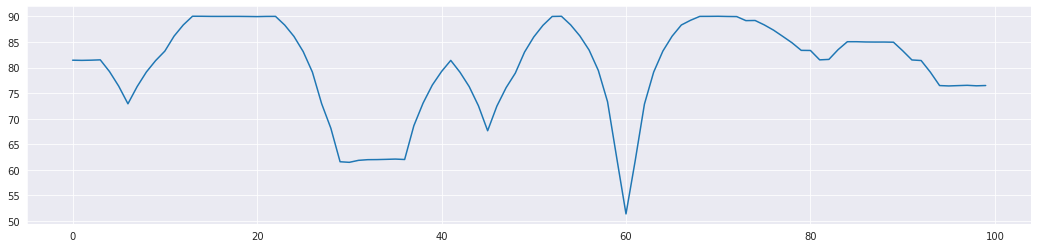

246.08759999275208


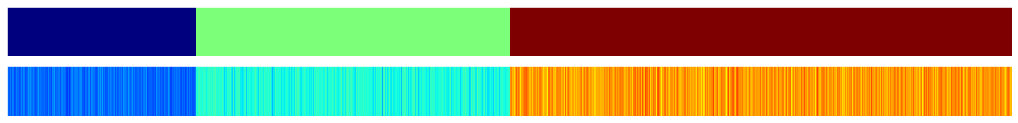

[[ 495491  442570       0]
 [ 351690 1207674       0]
 [  90517 1082465 1322593]]
0.606


In [5]:
f = gzip.open('data_hmm_004a.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

model_r = hmm.GaussianHMM(n_components=K, covariance_type="diag", n_iter=20000, tol=0.0001)
t0 = time.time()
model_r = model_r.fit(X, lengths=L)
print(time.time() - t0)
Z_hat_hmmlearn = model_r.predict(X)

perm = find_permutation(Z_hat_hmmlearn, Z)
make_plots(Z, perm[Z_hat_hmmlearn])

In [6]:
model_r.score(X, lengths=L)

-10352963.03942099

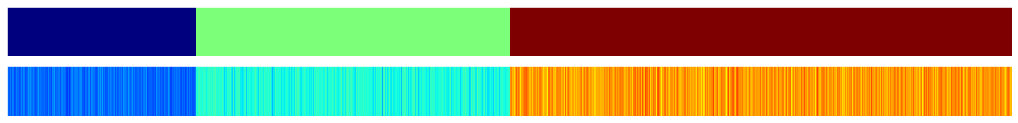

[[ 495491  442570       0]
 [ 351690 1207674       0]
 [  90517 1082465 1322593]]
0.606


In [7]:
perm_hmmlearn = find_permutation(Z_hat_hmmlearn, Z)
make_plots(Z, perm_hmmlearn[Z_hat_hmmlearn])

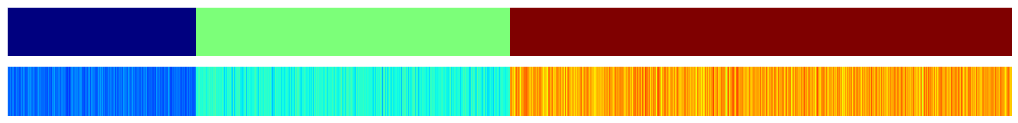

[[ 491059  446998       4]
 [ 349431 1209918      15]
 [  84697 1153897 1256981]]
0.5924209893851392


In [8]:
switch = np.arange(Z_hat_hmmlearn[1:].shape[0])[Z_hat_hmmlearn[1:] != Z_hat_hmmlearn[:-1]] + 1
switch = np.concatenate([np.array([0]), switch])
real_switch = np.concatenate([np.array([0]), switch[1:][(switch[1:] - switch[:-1]) > 3], np.array([Z_hat_hmmlearn.shape[0]])])
Z_hat_post = np.concatenate([(np.bincount(Z_hat_hmmlearn[real_switch[i]:real_switch[i + 1]]).argmax() * np.ones(
    Z_hat_hmmlearn[real_switch[i]:real_switch[i + 1]].shape[0])).astype(int) for i in range(real_switch.shape[0] - 1)])
perm = find_permutation(Z_hat_post, Z)
make_plots(Z, perm[Z_hat_post])

## Gaussian Dense HMM

In [9]:
from models_gaussian_2d import GaussianDenseHMM
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

2022-12-04 19:54:08.016795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 19:54:10.621060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 19:54:10.621186: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-04 19:54:20.536218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
def compute_stationary(M, verbose=True):
    eigval, eigvec = np.linalg.eig(M.T)
    idx = np.asarray(np.isclose(eigval, [1.], rtol=1e-2, atol=1e-3)).nonzero()[0]
    if idx.size < 1:
        raise Exception("No Eigenvalue 1")
    elif idx.size > 1 and verbose:
        print("Warning: Multiple vectors corresponding to eigenvalue 1.: %s" % str(idx))
    M_stationary = eigvec[:, idx[0]].real
    M_stationary = M_stationary / np.sum(M_stationary)
    return M_stationary

def relu(x):
    return x * (x > 0)

def compute_loss(nodes, splits, n_, omega_gt, means_, covars_, A_):
    B_scalars = None
    if d == 1:  # popraw wizualnie
        B_scalars_tmp = .5 * (
                1 + erf((nodes - np.transpose(a=means_)) / (
                relu(np.transpose(a=covars_[:, :, 0])) + 1e-10) / np.sqrt(2)))

        B_scalars = np.transpose(a=B_scalars_tmp[1:, :] - B_scalars_tmp[:-1, :])
    if d == 2:
        B_scalars_tmp = np.prod(.5 * (
                1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(
            np.transpose(a=means_), axis=0)) / (
                                relu(np.expand_dims(np.transpose(np.array(list(map(lambda x: np.diag(np.array(x)), covars_.tolist())))), axis=0)) + 1e-10) / np.sqrt(2))), axis=1)

        # B_scalars_tmp = np.prod(input_tensor=.5 * (
        #                     1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(
        #                 np.transpose(means_), axis=0)) / (relu(np.expand_dims(np.transpose(covars_),
        #                                                                       axis=0)) + 1e-10) / np.sqrt(2))), axis=1)

            # np.prod(.5 * (
            #     1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(np.transpose(a=means_), axis=0)) /
            #             (relu(np.expand_dims(np.transpose(np.array(list(map(lambda x: np.diag(np.array(x)), covars_.tolist())))), axis=0)) + 1e-10) /
            #             np.sqrt(2))), axis=1)
        B_scalars_tmp_wide = np.reshape(B_scalars_tmp, (*[n.shape[0] for n in splits], n_))
        B_scalars = np.transpose(a=np.reshape(
            B_scalars_tmp_wide[:-1, 1:, :] - B_scalars_tmp_wide[:-1, :-1, :] - B_scalars_tmp_wide[1:, 1:,
                                                                               :] + B_scalars_tmp_wide[1:, :-1, :],
            (-1, n_)))

    A_stationary = compute_stationary(A_, verbose=False)

    theta = A_ * A_stationary[:, None]
    omega = np.matmul(np.transpose(a=B_scalars), np.matmul(theta, B_scalars))
    loss_cooc = np.sum(np.abs(omega_gt - omega)) / 2
    return loss_cooc

def provide_nodes(n_, Y_train):
    kmeans = KMeans(n_).fit(Y_train)
    dtree = DecisionTreeClassifier().fit(Y_train, kmeans.labels_)

    splits = np.concatenate([dtree.tree_.feature.reshape(-1, 1), dtree.tree_.threshold.reshape(-1, 1)], axis=1)
    splits = np.concatenate([splits, np.array([[i, fun(Y_train[:, i])] for i, fun in itertools.product(range(Y_train.shape[1]), [
        lambda x: np.min(x) - 1e-3, lambda x: np.max(x) + 1e-3])])])
    splits = splits[splits[:, 0] >= 0]

    nodes_x = [np.sort(splits[splits[:, 0] == float(i), 1]) for i in np.unique(splits[:, 0])]
    nodes = np.array([t for t in itertools.product(*nodes_x)])

    splits = nodes_x  # number  of splits  on each axis
    discrete_nodes = nodes.astype('float32')
    discrete_observables = [n.shape[0] - 1 for n in nodes_x]

    indexes = np.arange(np.prod(discrete_observables)).reshape(discrete_observables)  # .transpose()
    Y_train_disc = np.array([indexes[i] for i in
                       zip(*[(Y_train[:, j].reshape(-1, 1) > splits[j].reshape(1, -1)).sum(axis=1) - 1 for j in
                             range(len(splits))])])

    return nodes, nodes_x, Y_train_disc

def _lengths_iterator(seqs, lengths):
    n_seqs = len(lengths)
    left, right = 0, 0

    for i in range(len(lengths)):
        right += lengths[i]
        yield seqs[left:right]
        left += lengths[i]

def empirical_coocs(seqs, m, lengths=None):
    freqs = np.zeros((m, m))
    seq_iterator = seqs
    if lengths is not None:
        seq_iterator = _lengths_iterator(seqs, lengths)

    for seq in seq_iterator:

        if seq.shape[0] <= 1:  # no transitions
            continue

        seq = seq.reshape(-1)

        seq_pairs = np.dstack((seq[:-1], seq[1:]))
        seq_pairs, counts = np.unique(seq_pairs, return_counts=True, axis=1)
        seq_pre, seq_suc = [arr.flatten() for arr in np.dsplit(seq_pairs, 2)]
        freqs[seq_pre, seq_suc] += counts

    return freqs, freqs / np.sum(freqs)

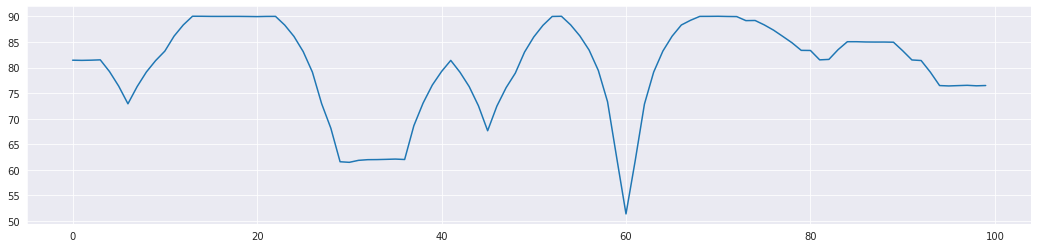

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2022-12-04 19:55:13.657820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-04 19:55:13.657882: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 19:55:13.657914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-12-04 19:55:13.660582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 19:55:13.773668: I tensorflow/compiler/mlir/mlir_graph_optimizat

0.5736198905105064


         2   -59304897.1079    +4570823.8055


0.2808089792381975


         3   -57969417.2857    +1335479.8222


0.05138932287137936


         4   -57799226.5233     +170190.7624


0.012150740575032872


         5   -57768115.0405      +31111.4828


0.0056267891508598325


         6   -57758623.8826       +9491.1579


0.0034824233660069493


         7   -57756629.1065       +1994.7761


0.0024081303954313713


         8   -57758485.9358       -1856.8293


0.001776942379268431


         9   -57762349.3035       -3863.3678


0.0013832326119805657


        10   -57767069.4724       -4720.1689


0.0011293796361428541


        11   -57771934.7349       -4865.2625


0.0009613787317215048


        12   -57776530.3168       -4595.5819


0.0008475590452569078


        13   -57780636.0402       -4105.7234


0.0007687335650468732


        14   -57784153.7781       -3517.7379


0.0007129692406633998


        15   -57787058.7283       -2904.9503


0.0006726673355604719


        16   -57789368.0234       -2309.2951


0.0006428860588116793


        17   -57791121.1176       -1753.0942


0.0006203519257022009


        18   -57792367.8411       -1246.7235


0.0006028621801299407


        19   -57793161.3143        -793.4732


0.0005889147544781301


        20   -57793553.8879        -392.5736


0.0005774739516350402


        21   -57793594.9413         -41.0534


0.0005678190537128923


        22   -57793329.8076        +265.1337


0.0005594447480586724


        23   -57792799.3686        +530.4390


0.0005519945996105843


        24   -57792040.0400        +759.3286


0.0005452159890636269


        25   -57791083.9733        +956.0667


0.0005389292250940745


        26   -57789959.3694       +1124.6040


0.0005330061533989755


        27   -57788690.8401       +1268.5293


0.0005273552115938364


        28   -57787299.7812       +1391.0589


0.0005219109094599224


        29   -57785804.7337       +1495.0475


0.0005166263780597143


        30   -57784221.7230       +1583.0107


0.0005114680657876718


        31   -57782564.5703       +1657.1527


0.0005064119478274098


        32   -57780845.1733       +1719.3970


0.000501440809369542


        33   -57779073.7572       +1771.4161


0.000496542294817358


        34   -57777259.0977       +1814.6595


0.0004917075058618762


        35   -57775408.7166       +1850.3811


0.0004869299942290165


        36   -57773529.0543       +1879.6623


0.00048220503895389565
163.7514374256134


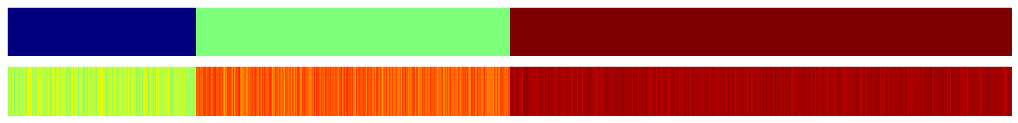

[[ 160520  469424  308117]
 [  31556  527092 1000716]
 [      0  169974 2325601]]
0.6034874824754657


In [11]:
f = gzip.open('data_hmm_004a.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

n = 3
d = 1
Y = X
lengths = np.array([Y.shape[0]])

nodes, splits, Y_disc = provide_nodes(n, Y)
_, omega_gt = empirical_coocs(Y_disc.reshape(-1, 1), np.max(Y_disc) + 1, lengths=lengths)
model = GaussianDenseHMM(n_hidden_states=n, mstep_config={'cooc_epochs': 12000 * n, 'cooc_lr': 0.003, 'loss_type': 'square'}, n_dims=d,
                         verbose=True, early_stopping=True, convergence_tol=0.0001, covariance_type='diag')
t0 = time.time()
model.fit_coocs(Y, lengths=L)
print(time.time() - t0)
Z_hat = model.predict(Y, L)

perm = find_permutation(Z_hat, Z)
make_plots(Z, perm[Z_hat])

In [12]:
model.score(Y, lengths=L)

-57771627.53367216

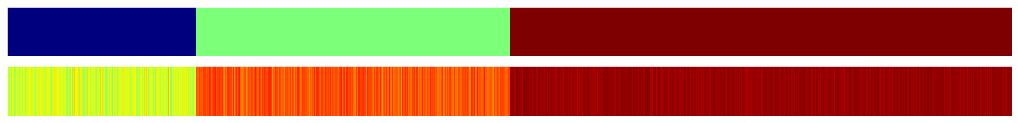

[[ 147275  435760  355026]
 [  16211  520936 1022217]
 [     24  114411 2381140]]
0.610725215301422


In [13]:
switch = np.arange(Z_hat[1:].shape[0])[Z_hat[1:] != Z_hat[:-1]] + 1
switch = np.concatenate([np.array([0]), switch])
real_switch = np.concatenate([np.array([0]), switch[1:][(switch[1:] - switch[:-1]) > 3], np.array([Z_hat.shape[0]])])
Z_hat_post = np.concatenate([(np.bincount(Z_hat[real_switch[i]:real_switch[i + 1]]).argmax() * np.ones(
    Z_hat[real_switch[i]:real_switch[i + 1]].shape[0])).astype(int) for i in range(real_switch.shape[0] - 1)])
perm = find_permutation(Z_hat_post, Z)
make_plots(Z, perm[Z_hat_post])

In [14]:
def make_plots2(Z, Z_hat, Z_hat2):
    order = Z.argsort()

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,2), sharey=True)
    ax1.imshow(Z[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax1.set_xticks([])
    # plt.sca(ax1)
    ax2.set_yticks([])
    ax1.set_ylabel("Ground Truth", rotation=0, ha='right')

    ax2.imshow(Z_hat[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax2.set_xticks([])
    # plt.sca(ax2)
    ax2.set_yticks([])
    ax2.set_ylabel("Standard Gaussian HMM", rotation=0, ha='right')

    ax3.imshow(Z_hat2[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat2.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax3.set_xticks([])
    # plt.sca(ax3)
    ax2.set_yticks([])
    ax3.set_ylabel("Gaussian Dense HMM", rotation=0, ha='right')
    plt.suptitle("Overall Consistency of the States")
    plt.show()

    cm = confusion_matrix(Z_hat2, Z_hat)

    cm_best_ = cm.copy()
    cm_best_a_ = np.diag(cm_best_).sum()
    for p in itertools.permutations(np.arange(cm.shape[0])):
        cm_ = cm[p, :].copy()
        cm_a_ = np.diag(cm_).sum()
        if cm_a_ > cm_best_a_:
            cm_best_ = cm_.copy()
            cm_best_a_ = cm_a_
    print(cm_best_)
    print(cm_best_a_ / cm_best_.sum())

In [15]:
perm = find_permutation(Z_hat, Z)

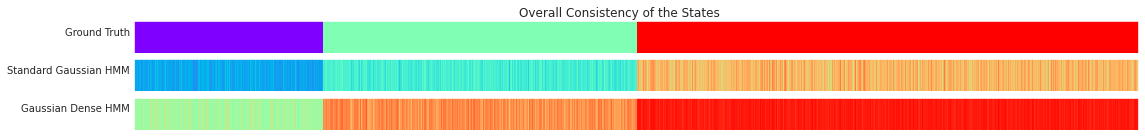

[[ 743254  423236       0]
 [   2368 2309473 1322593]
 [ 192076       0       0]]
0.6114013619066694


In [16]:
make_plots2(Z, perm_hmmlearn[Z_hat_hmmlearn], perm[Z_hat])

In [39]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 0].mean())
print(((Z != 0) == (perm_hmmlearn[Z_hat_hmmlearn] != 0))[Z != 0].mean())

0.5282076538732555
0.8909460783503772


In [40]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 1].mean())
print(((Z != 1) == (perm_hmmlearn[Z_hat_hmmlearn] != 1))[Z != 1].mean())

0.7744657437262884
0.5558542023674029


In [41]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 2].mean())
print(((Z != 2) == (perm_hmmlearn[Z_hat_hmmlearn] != 2))[Z != 2].mean())

0.5299752562034802
1.0


In [42]:
print((Z == perm[Z_hat])[Z == 0].mean())
print(((Z != 0) == (perm[Z_hat] != 0))[Z != 0].mean())
print((Z == perm[Z_hat])[Z == 1].mean())
print(((Z != 1) == (perm[Z_hat] != 1))[Z != 1].mean())
print((Z == perm[Z_hat])[Z == 2].mean())
print(((Z != 2) == (perm[Z_hat] != 2))[Z != 2].mean())

0.17111893576217324
0.9922178853985226
0.3380172942302118
0.8137839887512829
0.9318898450256955
0.4759270048149594


In [33]:
Z.shape

(4993000,)

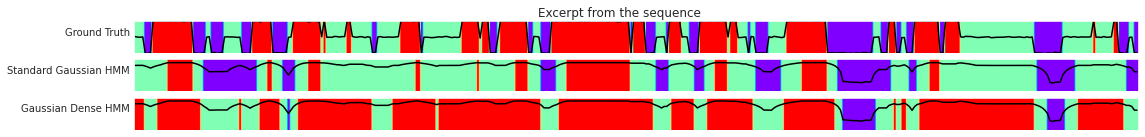

In [38]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,2), sharey=True)
ax1.plot(X_[7:400], color='Black')
ax1.imshow(Z[:393].reshape(1, -1), aspect="auto", extent=(-0.5, Z[:393].shape[0] - 0.5, 0, 110), cmap="rainbow")
ax1.set_xticks([])
# plt.sca(ax1)
ax2.set_yticks([])
ax1.set_ylabel("Ground Truth", rotation=0, ha='right')

ax2.plot(X[:393], color='Black')
ax2.imshow(perm_hmmlearn[Z_hat_hmmlearn][:393].reshape(1, -1)[:100], aspect="auto", extent=(-0.5, Z_hat_hmmlearn[7:400].shape[0] - 0.5, 0, 100), cmap="rainbow")
ax2.set_xticks([])
# plt.sca(ax2)
ax2.set_yticks([])
ax2.set_ylabel("Standard Gaussian HMM", rotation=0, ha='right')

ax3.plot(X[:393], color='Black')
ax3.imshow(perm[Z_hat][:393].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat[7:400].shape[0] - 0.5, 0, 100), cmap="rainbow")
ax3.set_xticks([])
# plt.sca(ax3)
ax2.set_yticks([])
ax3.set_ylabel("Gaussian Dense HMM", rotation=0, ha='right')
plt.suptitle("Excerpt from the sequence")
plt.show()

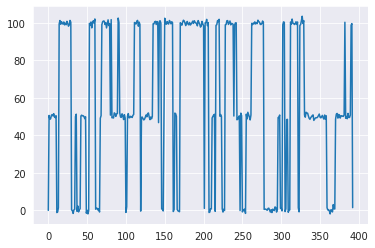

In [27]:
plt.plot(X_[:393])